In [7]:
# import all
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

In [6]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [22]:
%matplotlib inline

In [ ]:
RED = TrafficLight.RED
GREEN = TrafficLight.GREEN
YELLOW = TrafficLight.YELLOW
UNKNOWN = TrafficLight.UNKNOWN

In [10]:
RED = 'RED'
GREEN = 'GREEN'
YELLOW = 'YELLOW'
UNKNOWN = 'UNKNOWN'

In [17]:
class TrafficLightClassifier(object):
    def __init__(self):
        PATH_TO_MODEL = 'frozen_inference_graph.pb'
        PATH_TO_LABELS = 'data/sim_label_map.pbtxt'
        NUM_CLASSES = 3
        
        self.image_np = None
        
        # Loading the lable map
        label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
        categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
        self.category_index = label_map_util.create_category_index(categories)
        
        # load a FROZEN TF model into memory        
        self.detection_graph = tf.Graph()
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            # Works up to here.
            with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
                serialized_graph = fid.read()
                od_graph_def.ParseFromString(serialized_graph)
                tf.import_graph_def(od_graph_def, name='')
            self.image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0')
            self.d_boxes = self.detection_graph.get_tensor_by_name('detection_boxes:0')
            self.d_scores = self.detection_graph.get_tensor_by_name('detection_scores:0')
            self.d_classes = self.detection_graph.get_tensor_by_name('detection_classes:0')
            self.num_d = self.detection_graph.get_tensor_by_name('num_detections:0')
        #self.sess = tf.Session(graph=self.detection_graph) #, config=config
        self.sess = tf.Session(graph=self.detection_graph, config=config)
        
        
    def get_classification(self, img):
        # Bounding Box Detection.
        with self.detection_graph.as_default():
            # Expand dimension since the model expects image to have shape [1, None, None, 3].
            img_expanded = np.expand_dims(img, axis=0)  
            (boxes, scores, classes, num) = self.sess.run(
                [self.d_boxes, self.d_scores, self.d_classes, self.num_d],
                feed_dict={self.image_tensor: img_expanded})
            
            boxes = np.squeeze(boxes)
            classes = np.squeeze(classes).astype(np.int32)
            scores = np.squeeze(scores)
            
            min_score_thresh = .5            
            current_light = UNKNOWN
            
            for i in range(boxes.shape[0]):
                if scores is None or scores[i] > min_score_thresh:
                    class_name = self.category_index[classes[i]]['name']
                    # class_id = self.category_index[classes[i]]['id']
                    #print(class_name)
                    
                    if class_name == 'red':
                        current_light = RED
                    elif class_name == 'green':
                        current_light = GREEN
                    elif class_name == 'yellow':
                        current_light = YELLOW                              
            
            # Visualization of the results of a detection.
            vis_util.visualize_boxes_and_labels_on_image_array(img,
                  boxes,
                  classes,
                  scores,
                  self.category_index,
                  use_normalized_coordinates=True,
                  line_thickness=4)
            
            self.image_np = img
            
        return current_light

In [18]:
tlc  =TrafficLightClassifier()

In [13]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [19]:
test_img_path = 'test_images/yellow4.png'
test_img = Image.open(test_img_path)
img = load_image_into_numpy_array(test_img)

In [20]:
light = tlc.get_classification(img)
light

'YELLOW'

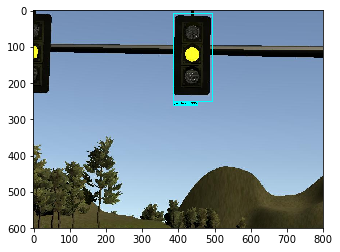

In [23]:
plt.imshow(tlc.image_np)